## Decisions logic

Game choice logic:
- Somewhat nieche games with an assumed older audience, so reviews will be more constructive and 
  objective as oposed to having jokes or other off topic content;
- A decent number of reviews and a good balance between positive and negative with little varience overtime.

|      GAME       |  APPID  | POSITIVE REVIEWS | NEGATIVE REVIEWS | PERCENT | TOTAL |
|      :---       |   ---:  |      :---:       |       :---:      |  :---:  | :---: |
| F1 Manager 2024 | 2591280 |       1652       |        830       |   65%   | 2482  |
| Trials Fusion   |  245490 |       1550       |        734       |   66%   | 2284  |

As of 2024/10/12, no filters

---

How does Steam rating work?

<img src="./image/steam-rating.png" width="540px" height="540px" alt="A table with how steam reviews ratings labeling problably translate to recommended percentage">

---

Why leave the filter_offtopic_activity on:  
From [Steam docs](https://partner.steamgames.com/doc/store/reviews#ReviewBombing) on "Review Bombing":

> In all examples, the surge of volume and sentiment will calm down after a few days.
> The reviews during that period will be bucketed by Steam and identified as such by your customers.
> In the case of **off-topic bombs, those reviews will not contribute to your overall score**.
>
> The majority of reviews associated with bombs aren't typically marked as helpful.
> Once the campaign is over, it's less likely that they will be surfaced in your review feed.
> *We also haven't seen a correlation between review bombs and purchasing behavior.*


## Imports and downloads


In [1]:
import datetime
import io
import logging
import re
import urllib.parse
from string import punctuation
from typing import Any

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import streamlit as st
from nltk import FreqDist, ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.util import is_cjk
from rich import print as rprint
from rich.logging import RichHandler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

In [2]:
_ = nltk.download("punkt_tab")
_ = nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data acquisition and formatting

### Logger e Misc


In [3]:
logger: logging.Logger = logging.getLogger(__name__)
logger.addHandler(RichHandler(rich_tracebacks=True))
logger.setLevel(logging.INFO)

In [4]:
pd.options.styler.format.precision = 3

### Game Class

In [5]:
class Game:
    """
    A class for working with Steam reviews.

    Attributes:
        name (str): The name of the game.
        appid (str): The Steam App ID of the game.
        params (dict[str, str]): The parameters for the Steam API call, in sorted order.
        cursor (dict[str, str]): The cursor parameter, as a dict.
        url (str): The URL for the Steam API call, with the parameters encoded in sorted order, excluding the cursor.
    """

    _root_url: str = "https://store.steampowered.com/appreviews/"

    _base_params: dict[str, str] = {
        "filter": "updated",  # all (default), recent, updated. all always returns --> can return duplicates
        "language": "english",  # english, brazilian, all ...
        # "day_range": "365",  # range from now to n days ago to look for helpful reviews. Only applicable for the "all" filter. Maximum value is 365.
        # "cursor": "*",  # Initial value
        # "review_type": "all",  # all (default), positive, negative
        "purchase_type": "all",  # all, non_steam_purchase, steam (default)
        "num_per_page": "100",  # Max=100, default=20
        # "filter_offtopic_activity": "1",  # aka. "Review Bombing". 0 to include, by default filter
    }  # https://partner.steamgames.com/doc/store/getreviews

    def __init__(
        self, name: str, appid: str, params: dict[str, str] = {}, cursor_val: str = "*"
    ):
        self._name: str = name.strip()
        self._appid: str = appid.strip()
        self._params: dict[str, str] = dict(
            sorted({**self._base_params, **params}.items())
        )
        self._cursor: dict[str, str] = {"cursor": f"{cursor_val}"}
        self._clear_url: str = f"{self._root_url}{self._appid}?json=1"
        self.url: str = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"
        self.req_df: pd.DataFrame = pd.DataFrame()
        self.df: pd.DataFrame = pd.DataFrame()
        self.df.columns.name = self.name
        logger.debug(self)

    @property
    def name(self) -> str:
        """The name of the game."""
        return self._name

    @property
    def appid(self) -> str:
        """The Steam App ID of the game as a string."""
        return self._appid

    @property
    def cursor(self) -> dict[str, str]:
        """The cursor parameter, as a dict."""
        return self._cursor

    @cursor.setter
    def cursor(self, cursor_value: str) -> None:
        """Set the VALUE of the cursor key in the dictionary object of the same name (cursor).

        Set value to '' if value can't be converted to string."""

        try:
            self._cursor["cursor"] = str(cursor_value)
        except (TypeError, ValueError):
            logger.exception(
                "Failed conversion to string of cursor value provided ('%s'), defaulting to ''",
                cursor_value,
            )
            self._cursor["cursor"] = ""

    def get_params(self, key: str | None = None) -> dict[str, str] | str:
        """Returns the params dictionary. If key is provided, returns the value of that key."""
        return self._params.get(key, "") if key else self._params

    def update_params(self, new_params: dict[str, str]) -> None:
        """Update params. If keys match values from new_params will override original params's,
        else, new (key, value) pairs will be added.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted({**self._params, **new_params}.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def set_params(self, new_params: dict[str, str]) -> None:
        """Overrides original params with new_params.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted(new_params.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def __repr__(self) -> str:
        return f"Game(name='{self._name}', appid={self._appid},\nparams={self._params},\ncursor={self._cursor},\nurl={self.url})"


### Requests code


In [6]:
def check_json_header(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> bool:
    """Checks if the response header contains "json" in its Content-Type.

    Returns True if it does contain.
    If the response status code is an error it raises an exception.
    """
    try:
        r: requests.Response = session.head(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        if r.status_code != 200:
            logger.warning(
                "Got code <[%s]: %s> when checking header for URL: %s",
                r.status_code,
                r.reason,
                r.url,
            )
        return "json" in r.headers["Content-Type"]
    except KeyError as e:
        logger.error(
            "KeyError: %s\nWhen accessing the header content from url= %s", e, url
        )
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET header from url= %s", type(e).__name__, e, url
        )
    return False


def get_reviews(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> requests.Response:
    """Sends a GET request.

    If the response status code is not an error it returns the response else it raises an exception.
    """
    try:
        r: requests.Response = session.get(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        return r
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET reviews from url= %s\n%s",
            type(e).__name__,
            e,
            url,
            cursor,
        )
        raise e from None


def content_to_json(r: requests.Response) -> dict[str, Any]:
    """Converts the response content to a JSON object.

    Returns a dict representation of the JSON or raises an exception if it fails."""
    try:
        return r.json()
    except requests.JSONDecodeError as e:
        logger.error(
            "JSONDecodeError: %s\nWhen trying to convert response to json from url= %s",
            e,
            r.url,
        )
        raise e from None


def reviews_requests_task(
    url: str,
    max_reviews: int = 10000,
    timeout: int = 6,
    cursor_val: str = "*",
    **kwargs,
) -> tuple[list[dict[str, Any]], dict[str, Any]]:
    """reviews_task Get all the reviews for a Steam game quering the public Steam API.

    Args:
        url (str): URL to the Steam API with the query parameters, except for cursor.
        max_reviews (int, optional): Maximum number of reviews to return. Defaults to 10000.
        timeout (int, optional): Time in seconds for the requests to time out. Defaults to 6.
        cursor_val (str, optional): Cursor value  to get the next batch. Defaults to '*'.
        **kwargs: Any other keyword arguments.

    Returns:
        tuple[list[dict[str, Any]], dict[str, Any]]: A tuple with a List of reviews, and the query summary.
    """

    # Simple debug hook
    def debug_responses(r: requests.Response, *args, **kwargs) -> None:
        """Simple debugging function to log the response code and url for every request response.
        Intened to be used as a hook."""
        logger.debug("Code= <[%s]: %s> \t%s\n", r.status_code, r.reason, r.url)

    # Create the cursor object
    cursor: dict[str, str] = {"cursor": cursor_val}

    # Create empty list of reviews
    reviews: list[dict[str, Any]] = []
    # Create empty query summary
    qs: dict[str, Any] = {}

    # Create a requests Session
    with requests.Session() as s:
        # Add debug hook
        s.hooks["response"].append(debug_responses)

        # Get the header and check if API returns "json"
        if not check_json_header(s, url, cursor, timeout):
            return (reviews, qs)

        # Get the query summary and first batch of reviews
        try:
            r: requests.Response = get_reviews(s, url, cursor, timeout)
        except requests.RequestException:
            return (reviews, qs)

        # Convert response content to json
        try:
            j: dict[str, Any] = content_to_json(r)
        except requests.JSONDecodeError:
            return (reviews, qs)

        # Consume the first response and log query summary
        try:
            qs = j.pop("query_summary")
            logger.info(
                "GameID= %7s\n---------------\nPositive= %5s\nNegative= %5s\nReviews= %6s\n---------------\nRating= %7s",
                url.split("?")[0].split("/")[-1],
                qs["total_positive"],
                qs["total_negative"],
                qs["total_reviews"],
                qs["review_score_desc"],
            )

            # Define the number reviews to get based on max_reviews and available reviews
            max_reviews = (
                max_reviews
                if max_reviews < int(qs["total_reviews"])
                else int(qs["total_reviews"])
            )

            # Extract number of reviews per request
            num_revs: int = int(qs["num_reviews"])

            # Define number of GET requests to make
            num_req: int = int(np.ceil((max_reviews - num_revs) / num_revs))

            # Extract the cursor to get the next batch
            cursor["cursor"] = j.pop("cursor")

            # Extract the list of reviews
            reviews.extend((j.pop("reviews")))

            # Returns the list of reviews and the query summary if there are no more reviews to get
            if num_req <= 0:
                return (reviews, qs)

        except (KeyError, ValueError, TypeError) as e:
            logger.error(
                "%s: %s\nWhen accessing the json content 'query_summary' from url= %s",
                type(e).__name__,
                e,
                r.url,
            )
            return (reviews, qs)

        # Get the rest of the reviews
        logger.info(
            "Performing %3d GET requests to get %5d reviews...", num_req, max_reviews
        )
        for i in range(num_req):
            try:
                # Get the next batch of reviews
                r = get_reviews(s, url, cursor, timeout)
                # Convert to json
                j = content_to_json(r)
                # Update cursor
                cursor["cursor"] = j.pop("cursor")
                # Extend list of reviews
                reviews.extend((j.pop("reviews")))

            except (requests.RequestException, KeyError) as e:
                logger.error(
                    "%s: %s\nIn (%3d/%3d) iteration when trying to get remaining reviews.\nGot (%5d/%5d)",
                    type(e).__name__,
                    e,
                    (i + 1),
                    num_req,
                    len(reviews),
                    max_reviews,
                )
                return (reviews, qs)

    # Return the list of reviews and query summary
    logger.info("Success! Acquired %5d reviews.", len(reviews))
    return (reviews, qs)


### Dataframe factory

In [7]:
# Define empty dataframe
df_summary: pd.DataFrame = pd.DataFrame()


def build_df_summary(
    df_summary: pd.DataFrame, query_summary: dict[str, Any], game_name: str, **kwargs
) -> pd.DataFrame:
    """Build summary dataframe."""

    df_temp: pd.DataFrame = pd.DataFrame(query_summary, index=[game_name]).drop(
        columns="num_reviews"
    )
    df_temp["percent"] = (
        df_temp["total_positive"] * 100 / df_temp["total_reviews"]
    ).round(1)
    df_summary = (
        pd.concat([df_summary, df_temp])
        .reset_index(names="Game")
        .drop_duplicates(subset=["Game"], keep="last")
        .set_index("Game")
        .sort_index(key=lambda x: x.str.lower())
    )
    df_summary.columns.name = "Games Summary"
    return df_summary


def unix_to_datetime(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert unix timestamp to datetime."""
    df[cols] = df[cols].apply(lambda x: pd.to_datetime(x, unit="s"))


def datetime_to_unix(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert datetime to unix timestamp."""
    df[cols] = df[cols].apply(lambda x: x.timestamp())


def min_to_hours(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert minutes to hours."""
    df[cols] = df[cols].apply(lambda x: (x / 60.0).round(1))


def build_df(
    reviews_list: list[dict[str, Any]], game_name: str, **kwargs
) -> pd.DataFrame:
    """Create dataframe from reviews list."""

    # List of unwanted columns
    unwanted_cols: list[str] = [
        "recommendationid",
        "language",
        "timestamp_created",
        # "hidden_in_steam_china",
        # "steam_china_location",
        "primarily_steam_deck",
        "author_steamid",
        "author_deck_playtime_at_review",
    ]

    # List of datetime columns
    datetime_cols: list[str] = ["timestamp_updated", "author_last_played"]

    # List of timedelta columns
    timedelta_cols: list[str] = [
        "author_playtime_last_two_weeks",
        "author_playtime_forever",
        "author_playtime_at_review",
    ]

    # Create dataframe and drop unwanted columns
    df: pd.DataFrame = pd.json_normalize(data=reviews_list, sep="_").drop(
        columns=unwanted_cols
    )

    # Drop columns with constant value
    # df.drop(columns=df.nunique()[df.nunique() == 1].index.tolist(), inplace=True)

    # Convert unix timestamps to datetime
    unix_to_datetime(df, datetime_cols)

    # Convert min to hours
    min_to_hours(df, timedelta_cols)

    # Convert weighted_vote_score to numeric (float)
    df.weighted_vote_score = pd.to_numeric(df.weighted_vote_score)

    # Convert review to string
    df.review = df.review.astype("string")

    # Name the column header of dataframe
    df.columns.name = game_name

    # Log dataframe info
    buffer = io.StringIO()
    df.info(buf=buffer)
    logger.debug(buffer.getvalue())
    del buffer

    # Return the dataframe
    return df


### Task to GET data and build dataframes


In [8]:
def reviews_df_task(g: Game, **kwargs):
    """reviews_df_task Queries the Steam API and builds the reviews DataFrame and the summary DataFrame

    Note: Check https://partner.steamgames.com/doc/store/getreviews for dataframe legend

    Args:
        game (Game): Game object
        **kwargs: Keyword arguments to pass underlying functions

    Returns:
        tuple[Reviews: pd.DataFrame, Summary: pd.DataFrame]: The DataFrame of reviews from the game and the summary DataFrame
    """
    global df_summary
    reviews_list, query_summary = reviews_requests_task(g.url, **kwargs)
    try:
        df_summary = build_df_summary(df_summary, query_summary, g.name, **kwargs)  # pyright: ignore[reportUnboundVariable]
    except NameError:
        df_summary = pd.DataFrame()
        build_df_summary(df_summary, query_summary, g.name, **kwargs)

    df: pd.DataFrame = build_df(reviews_list, g.name, **kwargs)
    logger.info("Done! Reviews acquired and DataFrames build for game '%s'", g.name)
    display(df_summary.head())
    rprint(
        f"DataFrame has for game '{df.columns.name}' has:\nReviews={df.shape[0]} and Columns={df.shape[1]}"
    )
    display(df.sample(3))
    g.req_df = df.copy()
    g.df["label"] = df.loc[:, "voted_up"].astype(int)

In [9]:
game = Game("F1 Manager 2024", "2591280")
# g2 = Game("Trials Fusion", "245490")

In [10]:
reviews_df_task(game)

[11/07/24 14:01:22] INFO     GameID= 2591280                                                       ]8;id=296053;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\464236683.py\464236683.py]8;;\:]8;id=444189;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\464236683.py#132\132]8;;\
                             ---------------                                                                       
                             Positive=   800                                                                       
                             Negative=   439                                                                       
                             Reviews=   1239                                                                       
                             ---------------                                                                       
                             Rating=   Mixed                                                                       

                    INFO     Performing  12 GET requests to get  1239 reviews...                   ]8;id=134725;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\464236683.py\464236683.py]8;;\:]8;id=619847;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\464236683.py#174\174]8;;\

[11/07/24 14:01:26] INFO     Success! Acquired  1239 reviews.                                      ]8;id=335751;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\464236683.py\464236683.py]8;;\:]8;id=616446;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\464236683.py#201\201]8;;\

                    INFO     Done! Reviews acquired and DataFrames build for game 'F1 Manager      ]8;id=572922;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\2977162505.py\2977162505.py]8;;\:]8;id=205272;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\2977162505.py#22\22]8;;\
                             2024'                                                                                 

Games Summary,review_score,review_score_desc,total_positive,total_negative,total_reviews,percent
Game,,,,,,
F1 Manager 2024,5,Mixed,800,439,1239,64.6


DataFrame has for game 'F1 Manager 2024' has:
Reviews=1239 and Columns=16

F1 Manager 2024,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
926,Shouldn't have released the game in this state...,2024-07-26 15:48:54,False,4,0,0.52381,0,True,False,False,0,1,36.7,0.0,10.0,2024-10-11 06:15:51
838,"create a team is set in right direction, lets ...",2024-07-28 08:14:10,True,0,0,0.00000,0,True,False,False,0,1,263.7,14.8,24.0,2024-11-06 23:31:47
76,Super fun and enjoyable!,2024-10-09 22:31:41,True,0,0,0.00000,0,True,False,False,0,1,41.6,0.6,36.9,2024-10-27 20:07:50


#### Saving Dataframes

In [11]:
def load_feather_df(path: str) -> pd.DataFrame:
    try:
        df: pd.DataFrame = pd.read_feather(path)
        logger.info("Loaded dataframe from '%s'", path)
        return df
    except FileNotFoundError as e:
        logger.error(
            "%s: %s\nWhen trying to load the dataframe from '%s'",
            type(e).__name__,
            e,
            path,
        )
        return pd.DataFrame()


def save_df(df: pd.DataFrame) -> None:
    if "voted_up" in df.columns:
        filename: str = f"./data/df_requested-{re.sub(r'[^A-Za-z0-9]+', '_', df.columns.name)}.{datetime.date.today()}.feather"
    elif "label" in df.columns:
        filename: str = f"./data/df_processed-{re.sub(r'[^A-Za-z0-9]+', '_', df.columns.name)}.{datetime.date.today()}.feather"
    else:
        filename: str = f"./data/unknown_df-{re.sub(r'[^A-Za-z0-9]+', '_', df.columns.name)}.{datetime.date.today()}.feather"
    try:
        df.to_feather(filename)
        logger.info("DataFrame saved for game '%s' in '%s'", df.columns.name, filename)
    except Exception as e:
        logger.error(
            "%s: %s\nWhen trying to save the dataframe at '%s'",
            type(e).__name__,
            e,
            filename,
        )

In [12]:
save_df(game.req_df)

                    INFO     DataFrame saved for game 'F1 Manager 2024' in                          ]8;id=468474;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\955945739.py\955945739.py]8;;\:]8;id=360957;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12388\955945739.py#25\25]8;;\
                             './data/df_requested-F1_Manager_2024.2024-11-07.feather'                              

## Machine Learning

### Preprocessing

#### NaN treatment

In [13]:
def treat_NaN_req_df(g: Game) -> None:
    """check_NaN Checks if there are NaN values in the DataFrame and attemps to fix them inplace

    Args:
        df (pd.DataFrame): The DataFrame

    Returns:
        bool: True if there still are NaN values, False otherwise
    """

    def _remove_NaN(df: pd.DataFrame) -> bool:
        """fix_NaN Attemps to fixes NaN values inplace in the DataFrame.

        If NaN values are found in 'author_playtime_at_review', they are replaced with 0.0
        If Nan values are found in 'review', the entry is dropped

        Args:
            df (pd.DataFrame): The DataFrame with the NaN values

        Returns:
            bool: False if there still are NaN values, True otherwise
        """
        values = {"author_playtime_at_review": 0.0}
        df.fillna(values, inplace=True)
        df.dropna(subset=["review"], inplace=True)
        df.reset_index(drop=True, inplace=True)
        return not (df.isna().any().any())

    df: pd.DataFrame = g.req_df
    if not df.isna().any().any():
        rprint(f"DataFrame for game '{df.columns.name}' has no NaN values.")
        return None
    if _remove_NaN(df):
        rprint(
            f"DataFrame for game '{df.columns.name}' had NaN values, they have been resolved."
        )
        return None

    df_nan_mask = df.isna()
    text: str = f"DataFrame for game '{g.name}' has {df_nan_mask.sum().sum()} NaN values:\n{df_nan_mask.sum().loc[df_nan_mask.sum() > 0].sort_values(ascending=False).to_dict()}"
    logger.warning(text)
    # rprint(text)
    display(df.loc[df_nan_mask.any(axis=1)])
    return None

In [14]:
treat_NaN_req_df(game)

DataFrame for game 'F1 Manager 2024' has no NaN values.

#### Clean, Tokenize, Lemmatize

In [15]:
stopwords_edited: set[str] = {
    "i",
    "me",
    "my",
    "myself",
    "we",
    "our",
    "ours",
    "ourselves",
    "you",
    "you're",
    "you've",
    "you'll",
    "you'd",
    "your",
    "yours",
    "yourself",
    "yourselves",
    "he",
    "him",
    "his",
    "himself",
    "she",
    "she's",
    "her",
    "hers",
    "herself",
    "it",
    "it's",
    "its",
    "itself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
    "what",
    "which",
    "who",
    "whom",
    "this",
    "that",
    "that'll",
    "these",
    "those",
    "am",
    "is",
    "are",
    "was",
    "were",
    "be",
    "been",
    "being",
    "have",
    "has",
    "had",
    "having",
    "do",
    "does",
    "did",
    "doing",
    "a",
    "an",
    "the",
    "and",
    "but",
    "if",
    "or",
    "because",
    "as",
    "until",
    "while",
    "of",
    "at",
    "by",
    "for",
    "with",
    "about",
    "between",
    "into",
    "through",
    "to",
    "from",
    "again",
    "further",
    "then",
    "once",
    "here",
    "there",
    "when",
    "where",
    "why",
    "how",
    "any",
    "both",
    "each",
    "other",
    "such",
    "own",
    "so",
    "than",
    "too",
    "can",
    "will",
    "should",
    "should've",
    "now",
    "d",
    "ll",
    "m",
    "o",
    "re",
    "ve",
    "y",
    "ain",
    "aren",
    "aren't",
    "couldn",
    "couldn't",
    "didn",
    "didn't",
    "doesn",
    "doesn't",
    "hadn",
    "hadn't",
    "hasn",
    "hasn't",
    "haven",
    "haven't",
    "isn",
    "isn't",
    "ma",
    "mightn",
    "mightn't",
    "mustn",
    "mustn't",
    "needn",
    "needn't",
    "shan",
    "shan't",
    "shouldn",
    "shouldn't",
    "wasn",
    "wasn't",
    "weren",
    "weren't",
    "wo",
    "won't",
    "wouldn",
    "wouldn't",
    "in",
    "out",
}  # ? perhaps add 'like'


def clean_text(text: str) -> str:
    # Lower case
    text = text.lower()

    # Contract repetitions (>2)
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # Decontract
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"[\'`´]re", " are", text)
    text = re.sub(r"[\'`´]s", " is", text)
    text = re.sub(r"[\'`´]d", " would", text)
    text = re.sub(r"[\'`´]ll", " will", text)
    text = re.sub(r"[\'`´]ve", " have", text)
    text = re.sub(r"[\'`´]m", " am", text)

    # Strip markdown
    text = re.sub(r"\[.*?\]", "", text)

    # Define punctuation
    punct: str = re.sub(r"\?", "", punctuation + "‘’…“”⠄´")

    # Remove punctuation
    text = text.translate(str.maketrans("", "", punct))

    return text


def tok_lemma_text(text: str, lang: str = "english") -> list[str] | None:
    global stopwords_edited
    lemmatizer = WordNetLemmatizer()
    tokenizer = word_tokenize

    # Tokenize
    tokens: list[str] = tokenizer(text, language=lang)

    # Remove Stopwords
    tokens = [tok for tok in tokens if tok not in stopwords_edited]

    # Lemmatize and remove cjk chars
    cjk_flag: bool = False
    for i, tok in enumerate(tokens):
        if is_cjk(tok[0]):
            tokens[i] = ""
            cjk_flag = True
        else:
            tok = lemmatizer.lemmatize(tok, "n")
            tok = lemmatizer.lemmatize(tok, "v")
            tok = lemmatizer.lemmatize(tok, "a")
            tok = lemmatizer.lemmatize(tok, "r")
            tokens[i] = tok

    # Remove empty strings
    if cjk_flag:
        tokens = [t for t in tokens if t]

    # Return the tokens list or None if empty list
    return tokens if tokens else None


# def make_ngrams(sent: pd.DataFrame, *, max: int) -> list[str]:
#     ret: list[str] = []
#     kargs = {
#         "pad_left": True,
#         "pad_right": True,
#         "left_pad_symbol": "<s>",
#         "right_pad_symbol": "</s>",
#     }
#     for n in range(1, max + 1):
#         ret.extend(ngrams(sent, n, **kargs))  # pyright: ignore[reportArgumentType]

#     return ret


def apply_for_clean_text(g: Game):
    g.df["review"] = g.req_df["review"].apply(clean_text)


def apply_for_tok_lemma_tex(g: Game):
    g.df["words"] = g.df["review"].apply(
        tok_lemma_text, lang=game.get_params("language")
    )
    g.df.dropna(ignore_index=True, inplace=True) # pyright: ignore[reportCallIssue]


In [16]:
apply_for_clean_text(game)
apply_for_tok_lemma_tex(game)

### Visualization and Exploration

#### Distribution of label/target

In [17]:
def plot_label_distribution(df: pd.DataFrame, x: str = "label") -> None:
    """plot_target_distribution Plots the distributions of the target variable

    Args:
        df (pd.DataFrame): The DataFrame with the target variable

    Returns:
        None
    """
    fig, axs = plt.subplots(1, 2, layout="constrained")

    sns.countplot(data=df, x=x, hue=x, stat="count", legend=False, ax=axs[0])
    axs[0].set(xlabel="", ylabel=f"Count (total = {df.shape[0]})", title="Count")

    sns.countplot(data=df, x=x, hue=x, stat="percent", legend=False, ax=axs[1])
    axs[1].set(xlabel="", ylabel="Percentage (%)", title="Percentage")

    fig.suptitle(f"Game: {df.columns.name}")
    fig.supxlabel("Reviews")
    plt.show()

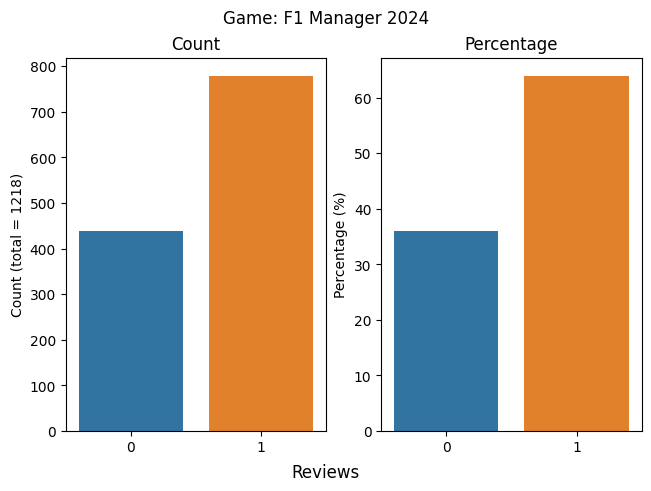

In [18]:
plot_label_distribution(game.df)

#### Term Frequency

In [19]:
def tf_summary(g: Game) -> FreqDist:
    """tf_summary Generates a frequency distribution for the words in the reviews. And analyzes the top 20 most common words.

    Args:
        g (Game): Game object

    Returns:
        FreqDist: Frequency distribution of the words in the reviews
    """
    fd = FreqDist(g.df["words"].explode().to_list())
    cumsum = 0

    for word in fd.most_common(20):
        cumsum += word[1]

    rprint(f"Top 20 most common words in reviews for '{g.name}':")

    fd.tabulate(20)

    rprint(
        f"This top 20 represents {cumsum*100/fd.N():.2f}% or {cumsum:,d} out of the {fd.N():,d} total frequencies.\n\nWhile 20 words represents {2000/fd.B():.2f}% out of the total {fd.B():,d} unique words."
    )

    fd.plot(20, title=f"Top 20 most common words in reviews for '{g.name}'", show=True)

    return fd

Top 20 most common words in reviews for 'F1 Manager 2024':

  game    not   team     on    bug   good driver   race    get     f1   like   just    car   make   play   more   some  still   time    fix 
  1832   1077    601    546    531    495    482    461    426    425    408    369    368    357    313    301    279    276    269    265 


This top 20 represents 20.92% or 10,081 out of the 48,185 total frequencies.

While 20 words represents 0.43% out of the total 4,671 unique words.

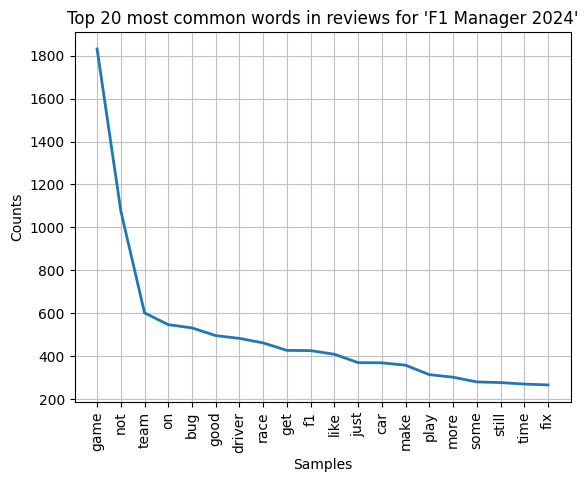

In [20]:
_ = tf_summary(game)

#### WordCloud

In [21]:
def plot_wordcloud(g: Game, bg: str = "black") -> None:
    wc = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=400,
    ).generate("".join([" ".join(w) for w in g.df.words]))

    plt.figure(figsize=(15, 8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

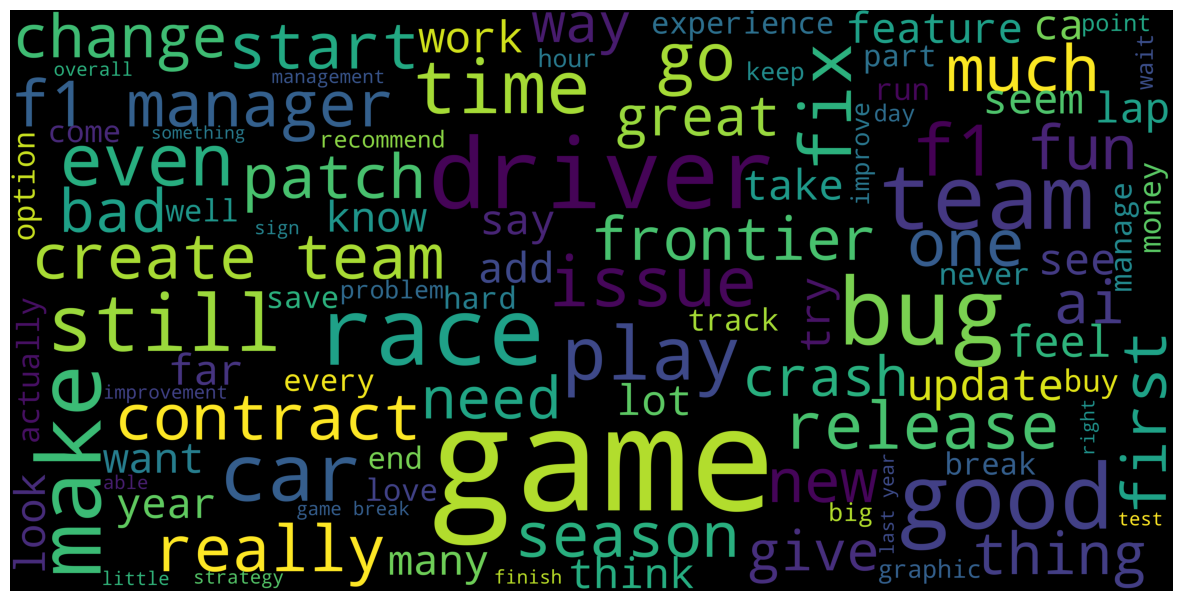

In [22]:
plot_wordcloud(game)

### Classification

#### Split Data

In [40]:
X = np.array(game.df["words"].str.join(" "))
y = game.df["label"].to_numpy(dtype="int")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)


#### TF-IDF

In [47]:
# def make_tf_idf(X, ngrams_low: int = 1, ngrams_high: int = 3):
#     tf_idf = TfidfVectorizer(
#         ngram_range=(ngrams_low, ngrams_high), smooth_idf=False, strip_accents="unicode"
#     )
#     tf_idf.fit(X)
#     return tf_idf

# tf_idf= make_tf_idf(X_train)
# Xt_train = tf_idf.transform(X_train)
# Xt_test = tf_idf.transform(X_test)

#### Pipeline e GridSearchCV

In [ ]:
pipes = []

pipes.append(
    Pipeline(
        [
            ("tfidf", TfidfVectorizer(smooth_idf=False, strip_accents="unicode")),
            ("classify", KNeighborsClassifier(metric="cosine")),
        ]
    )
)

pipes.append(
    Pipeline(
        [
            ("tfidf", TfidfVectorizer(smooth_idf=False, strip_accents="unicode")),
            ("classify", RandomForestClassifier()),
        ]
    )
)

pipes.append(
    Pipeline(
        [
            ("tfidf", TfidfVectorizer(smooth_idf=False, strip_accents="unicode")),
            ("classify", BernoulliNB()),  # Like MultinomialNB but for binary
        ]
    )
)

pipes.append(
    Pipeline(
        [
            ("tfidf", TfidfVectorizer(smooth_idf=False, strip_accents="unicode")),
            (
                "classify",
                MultinomialNB(),
            ),  # Not the best for idf, better for word counts
        ]
    )
)

pipes.append(
    Pipeline(
        [
            ("tfidf", TfidfVectorizer(smooth_idf=False, strip_accents="unicode")),
            ("classify", GaussianNB()),
        ]
    )
)


NGRAMS_OPTIONS = [(1, 1), (1, 2), (2, 3), (3, 3)]

param_grids = []

param_grids.append(
    {
        "tfidf__ngram_range": NGRAMS_OPTIONS,
        "classify__n_neighbors": [10, 50, 80, 100, 200, 400, 500],
    }
)
param_grids.append(
    {
        "tfidf__ngram_range": NGRAMS_OPTIONS,
        "classify__n_estimators": [50, 80, 100, 200, 400, 500],
        "classify__max_depth": [50, 100, 200, 300],
    }
)
param_grids.append(
    {
        "tfidf__ngram_range": NGRAMS_OPTIONS,
        "classify__binarize": [0.0, 0.3, 0.3, 0.5, 0.7],
    }
)
param_grids.append({"tfidf__ngram_range": NGRAMS_OPTIONS})

param_grids.append({"tfidf__ngram_range": NGRAMS_OPTIONS})

grids = []

for pipe, param in zip(pipes, param_grids):  # RandomizedSearchCV()
    grids.append(
        GridSearchCV(pipe, param_grid=param)
    )  # n_jobs, cv, scoring [accuracy/f1_weighted/precision/recall]

1 Run

---

``` python
grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), smooth_idf=False,
                                 strip_accents='unicode')),
                ('classify',
                 KNeighborsClassifier(metric='cosine', n_neighbors=200))])
grid.best_params_= {'classify__n_neighbors': 200, 'tfidf__ngram_range': (1, 2)}
grid.best_score_= np.float64(0.8388158289797634)



grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify',
                 RandomForestClassifier(max_depth=200, n_estimators=500))])
grid.best_params_= {'classify__max_depth': 200, 'classify__n_estimators': 500, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= np.float64(0.8310874917432294)


grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify', BernoulliNB())])
grid.best_params_= {'classify__binarize': 0.0, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= np.float64(0.7269801237014353)


grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify', MultinomialNB())])
grid.best_params_= {'tfidf__ngram_range': (1, 1)}
grid.best_score_= np.float64(0.8256290157929502)
```

2 Run

---

``` python
grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify',
                 KNeighborsClassifier(metric='cosine', n_neighbors=50))])
grid.best_params_= {'classify__n_neighbors': 50, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.829


c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify',
                 RandomForestClassifier(max_depth=300, n_estimators=500))])
grid.best_params_= {'classify__max_depth': 300, 'classify__n_estimators': 500, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.829


grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify', BernoulliNB())])
grid.best_params_= {'classify__binarize': 0.0, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.717


grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify', MultinomialNB())])
grid.best_params_= {'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.823
```

In [49]:
def run_exploration_big_gridsearchcv():
    b_grids = []
    for grid in grids:
        grid.fit(X_train, y_train)
        b_grids.append(grid)
        rprint(f"{grid.best_estimator_= }\n{grid.best_params_= }\n{grid.best_score_= :.3f}\n\n")

In [50]:
run_exploration_big_gridsearchcv()

grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify',
                 KNeighborsClassifier(metric='cosine', n_neighbors=50))])
grid.best_params_= {'classify__n_neighbors': 50, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.829

c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify',
                 RandomForestClassifier(max_depth=300, n_estimators=500))])
grid.best_params_= {'classify__max_depth': 300, 'classify__n_estimators': 500, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.829

grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify', BernoulliNB())])
grid.best_params_= {'classify__binarize': 0.0, 'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.717

grid.best_estimator_= Pipeline(steps=[('tfidf',
                 TfidfVectorizer(smooth_idf=False, strip_accents='unicode')),
                ('classify', MultinomialNB())])
grid.best_params_= {'tfidf__ngram_range': (1, 1)}
grid.best_score_= 0.823

ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\naive_bayes.py", line 263, in fit
    return self._partial_fit(
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\naive_bayes.py", line 423, in _partial_fit
    X, y = self._validate_data(X, y, reset=first_call)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\utils\validation.py", line 971, in check_array
    array = _ensure_sparse_format(
            ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rodrigo\.virtualenvs\ECM514_CD-eIUPckek\Lib\site-packages\sklearn\utils\validation.py", line 595, in _ensure_sparse_format
    raise TypeError(
TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.


In [51]:
# clf = KNeighborsClassifier(n_neighbors=200)
# clf.fit(Xt_train, y_train)
# y_pred = clf.predict(Xt_test)

# rprint(classification_report(y_test, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# plt.title("Confusion Matrix")
# plt.show()

## Main

In [52]:
df_summary: pd.DataFrame = pd.DataFrame()


def main_task(name: str, appid: str):
    global df_summary
    # Create game of class Game
    game = Game("F1 Manager 2024", "2591280")

    # Get dataframe for game data and a summary dataframe
    reviews_df_task(game)

    # Save requested dataframe locally in a .feather file
    save_df(game.req_df)

    # Treats NaN values
    treat_NaN_req_df(game)

    # Clean the text and populate game.df
    apply_for_clean_text(game)

    # Tokenize and lemmatize the text and populate game.df
    apply_for_tok_lemma_tex(game)

    # Display a sample of df
    display(game.df.sample(3))

    # Save preprocessed dataframe locally in a .feather file
    save_df(game.df)

    # Plot label distribution
    plot_label_distribution(game.df)

    # Generates the word frequency and analyzes of the top 20
    _ = tf_summary(game)

    # Plot WordCloud of the top 100 words
    plot_wordcloud(game)



# TODO:  classifing
# Run the task
# main_task("F1 Manager 2024", "2591280")